# Week 3 - Machine Learning and K-Nearest Neighbors
Week Three - August 8, 2022
Reminder, the author has all of the code available on [Github](https://github.com/joelgrus/data-science-from-scratch)

## Chapter 11 - Machine Learning



In [ ]:
import sys, os, random, math        # some of the basics
from typing import TypeVar, List, Tuple

# Setting up to use the author's library, cloned into the 'scratch' folder here (MIT License retained)
sys.path.insert(0,os.path.abspath('.'))

# ... and a few other external libraries to use... (again, use pip if on your local system)
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} tqdm

import matplotlib.pyplot as plt

### Bias and Variance

![Bias vs Variance](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png)
from [Cornell CS 4780](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html)

### Basic Types of Machine Learning

![Discriminative Learning](https://stanford.edu/~shervine/teaching/cs-229/illustrations/discriminative-model.png?767b34c21d43a4fd8b59683578e132f9)
![Generative](https://stanford.edu/~shervine/teaching/cs-229/illustrations/generative-model.png?df0642cec6e99ac162cd4848d26f41c3)
from [Standord CS-229 Cheatsheet](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning) 

### A More Comprehensive Map of ML

![ML Map](http://dlib.net/ml_guide.svg)
from [DLib C++ Library](https://dlib.net) 

### Curve Fitting
![XKCD 2048](https://imgs.xkcd.com/comics/curve_fitting.png)
from [XKCD 2048](https://xkcd.com) 

### Precision and Recall

![Precision](https://wikimedia.org/api/rest_v1/media/math/render/svg/5b7d5cd5010efe2ef51e7731f2124a2156830fbe)
![Recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/43a4548e95fde15433d8e3cd3c80ced433f54abe)

![Precision and Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)
from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

In [2]:
import random
from typing import TypeVar, List, Tuple
X = TypeVar('X')  # generic type to represent a data point

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

data = [n for n in range(1000)]
train, test = split_data(data, 0.75)

# The proportions should be correct
assert len(train) == 750
assert len(test) == 250

# And the original data should be preserved (in some order)
assert sorted(train + test) == data

Y = TypeVar('Y')  # generic type to represent output variables

def train_test_split(xs: List[X],
                     ys: List[Y],
                     test_pct: float) -> Tuple[List[X], List[X], List[Y], List[Y]]:
    # Generate the indices and split them.
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

xs = [x for x in range(1000)]  # xs are 1 ... 1000
ys = [2 * x for x in xs]       # each y_i is twice x_i
x_train, x_test, y_train, y_test = train_test_split(xs, ys, 0.25)

# Check that the proportions are correct
assert len(x_train) == len(y_train) == 750
assert len(x_test) == len(y_test) == 250

# Check that the corresponding data points are paired correctly.
assert all(y == 2 * x for x, y in zip(x_train, y_train))
assert all(y == 2 * x for x, y in zip(x_test, y_test))

def accuracy(tp: int, fp: int, fn: int, tn: int) -> float:
    correct = tp + tn
    total = tp + fp + fn + tn
    return correct / total

assert accuracy(70, 4930, 13930, 981070) == 0.98114

def precision(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fp)

assert precision(70, 4930, 13930, 981070) == 0.014

def recall(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fn)

assert recall(70, 4930, 13930, 981070) == 0.005

def f1_score(tp: int, fp: int, fn: int, tn: int) -> float:
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)

    return 2 * p * r / (p + r)

## Chapter 12 - K-Nearest Neighbors



In [ ]:
from typing import List
from collections import Counter
from typing import Dict
import csv
from collections import defaultdict

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)


import random

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

def parse_iris_row(row: List[str]) -> LabeledPoint:
        """
        sepal_length, sepal_width, petal_length, petal_width, class
        """
        measurements = [float(value) for value in row[:-1]]
        # class is e.g. "Iris-virginica"; we just want "virginica"
        label = row[-1].split("-")[-1]
    
        return LabeledPoint(measurements, label)
    
with open('data/iris.data') as f:
        reader = csv.reader(f)
        iris_data = [parse_iris_row(row) for row in reader]
    
# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
        points_by_species[iris.label].append(iris.point)
    
from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers
    
fig, ax = plt.subplots(2, 3)
    
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
    
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

plt.gcf().set_size_inches(15,10)    
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()
   


In [20]:

    
import random
from scratch.machine_learning import split_data
 
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150
  
from typing import Tuple
    
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
    
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
    
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)
print("Percent Correct: %s %%" % pct_correct)
print("Confusion Matrix: \n%s" % confusion_matrix)
    


Percent Correct: 0.9777777777777777 %
Confusion Matrix: 
defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


Curse of Dimensionality:   0%|          | 0/200 [00:00<?, ?it/s]

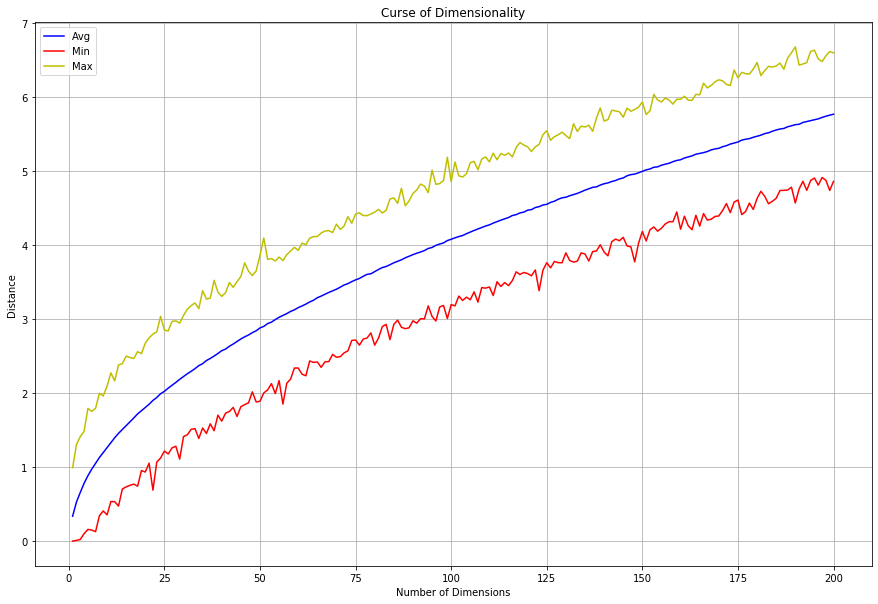

In [22]:
#plt.gca().clear()
from tqdm.notebook import tqdm
dimensions = range(1, 201)
    
avg_distances = []
min_distances = []
max_distances = []
    
random.seed(0)
for dim in tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 4000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 4000)  # track the average
    min_distances.append(min(distances))          # track the minimum
    max_distances.append(max(distances))          # track the minimum
    
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

fig, ax = plt.subplots()
ax.plot(dimensions, avg_distances, color='b', label='Avg')
ax.plot(dimensions, min_distances, color='r', label='Min')
ax.plot(dimensions, max_distances, color='y', label='Max')
plt.gcf().set_size_inches(15,10)
plt.xlabel("Number of Dimensions")
plt.ylabel("Distance")
plt.title("Curse of Dimensionality")
plt.grid(True, which='both')
plt.legend()
plt.show()